<a href="https://colab.research.google.com/github/MGentieu/Data_analytics_aircraft_messages/blob/main/GENTIEU_Martin_TP1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GENTIEU Martin : TP de data analytics

###On se place dans un premier temps dans le répertoire parent

In [24]:
import os
import sys
from pathlib import Path

# Detect working directory
cwd = Path.cwd().resolve()

# If in Colab (/content), search for repo folder automatically
if cwd.name == "content":
    # Look for the cloned project automatically
    candidates = [d for d in cwd.iterdir() if d.is_dir() and "aircraft" in d.name.lower()]

    if not candidates:
        raise FileNotFoundError(
            f"Aucun dossier contenant 'aircraft' trouvé dans /content.\n"
            f"Dossiers présents : {os.listdir(cwd)}"
        )

    PROJECT_ROOT = candidates[0]
else:
    PROJECT_ROOT = cwd

print(f"Detected project root: {PROJECT_ROOT}")

# Validate directory
if not PROJECT_ROOT.exists():
    raise FileNotFoundError(f"Missing directory at {PROJECT_ROOT}")

# Add to Python path
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("Setup complete.")


Detected project root: /content/Data_analytics_aircraft_messages
Setup complete.


On importe ensuite les bibliothèques nécessaires à l'analyse :

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import folium
import shapely
import socket
import csv
from datetime import datetime

On exécute ensuite le script python test.py pour récupérer les messages

In [26]:
HOST = "sbs.glidernet.org"
PORT = 30003

# Timestamp pour nommer le fichier
date = datetime.now().strftime('%Y%m%d_%H%M%S')

# Fichier CSV de sortie
output_file = f"{PROJECT_ROOT}/adsb_data_{date}.csv"

# Liste des colonnes SBS (22 champs)
cols = [
    "MessageType",
    "TransmissionType",
    "SessionID",
    "AircraftID",
    "HexIdent",
    "FlightID",
    "DateGenerated",
    "TimeGenerated",
    "DateLogged",
    "TimeLogged",
    "Callsign",
    "Altitude",
    "GroundSpeed",
    "Track",
    "Latitude",
    "Longitude",
    "VerticalRate",
    "Squawk",
    "Alert",
    "Emergency",
    "SPI",
    "IsOnGround"
]

print(f"Connexion à {HOST}:{PORT} ...")

with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
    s.connect((HOST, PORT))
    print("Connecté ! Réception des messages ADS-B...\n")

    # Création et ouverture du CSV
    with open(output_file, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f, delimiter=",")
        writer.writerow(cols)  # Header complet

        try:
            for _ in range(3000):  # Nombre de messages SBS à traiter
                data = s.recv(1024).decode(errors="ignore")

                for line in data.strip().split("\n"):
                    if line.startswith("MSG"):
                        fields = line.split(",")
                        # print(fields)

                        # Certain messages peuvent être plus courts → on complète
                        if len(fields) < len(cols):
                            fields += [""] * (len(cols) - len(fields))

                        writer.writerow(fields)

        except KeyboardInterrupt:
            print("\nArrêt manuel par l’utilisateur.")
        except Exception as e:
            print("Erreur :", e)

print(f"\nDonnées enregistrées dans : {output_file}")


Connexion à sbs.glidernet.org:30003 ...
Connecté ! Réception des messages ADS-B...


Données enregistrées dans : /content/Data_analytics_aircraft_messages/adsb_data_20251119_144610.csv


###1.1. Chargement du fichier avec la librairie pandas

In [27]:
df = pd.read_csv(output_file)
#df = df[0].str.split(",", expand=True)

Analyse initiale du dataset :

In [28]:
df.head()

,MessageType,TransmissionType,SessionID,AircraftID,HexIdent,FlightID,DateGenerated,TimeGenerated,DateLogged,TimeLogged,...,GroundSpeed,Track,Latitude,Longitude,VerticalRate,Squawk,Alert,Emergency,SPI,IsOnGround
0,MSG,3.0,NaN,NaN,3DD2AB,NaN,2025/11/19,14:46:10.430,2025/11/19,14:46:10.430,...,27.0,250.0,47.71707,14.03028,NaN,NaN,0.0,0.0,0.0,0.0
1,MSG,3.0,NaN,NaN,3D18EF,NaN,2025/11/19,14:46:10.432,2025/11/19,14:46:10.432,...,212.0,110.0,48.79108,13.02908,NaN,NaN,0.0,0.0,0.0,0.0
2,MSG,3.0,NaN,NaN,4B17FE,NaN,2025/11/19,14:46:10.434,2025/11/19,14:46:10.434,...,397.0,188.0,51.81750,9.40053,NaN,NaN,0.0,0.0,0.0,0.0
3,MSG,3.0,NaN,NaN,4D24F0,NaN,2025/11/19,14:46:10.436,2025/11/19,14:46:10.436,...,299.0,284.0,49.74658,9.29940,NaN,NaN,0.0,0.0,0.0,0.0
4,MSG,3.0,NaN,NaN,3C48F1,NaN,2025/11/19,14:46:10.438,2025/11/19,14:46:10.438,...,411.0,134.0,49.09108,10.32238,NaN,NaN,0.0,0.0,0.0,0.0


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5877 entries, 0 to 5876
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MessageType       5877 non-null   object 
 1   TransmissionType  5862 non-null   float64
 2   SessionID         0 non-null      float64
 3   AircraftID        0 non-null      float64
 4   HexIdent          5835 non-null   object 
 5   FlightID          0 non-null      float64
 6   DateGenerated     5773 non-null   object 
 7   TimeGenerated     5705 non-null   object 
 8   DateLogged        5599 non-null   object 
 9   TimeLogged        5490 non-null   object 
 10  Callsign          5424 non-null   object 
 11  Altitude          5370 non-null   float64
 12  GroundSpeed       5319 non-null   float64
 13  Track             5250 non-null   float64
 14  Latitude          5184 non-null   float64
 15  Longitude         5111 non-null   object 
 16  VerticalRate      0 non-null      float64


In [30]:
df.describe()

,TransmissionType,SessionID,AircraftID,FlightID,Altitude,GroundSpeed,Track,Latitude,VerticalRate,Squawk,Alert,Emergency,SPI,IsOnGround
count,5862.0,0.0,0.0,0.0,5370.000000,5319.000000,5250.000000,5184.000000,0.0,0.0,5073.0,5060.0,5045.0,5025.0
mean,3.0,NaN,NaN,NaN,9443.011732,203.267155,179.766476,46.556307,NaN,NaN,0.0,0.0,0.0,0.0
std,0.0,NaN,NaN,NaN,9344.648795,128.453346,105.810090,12.412097,NaN,NaN,0.0,0.0,0.0,0.0
min,3.0,NaN,NaN,NaN,0.000000,0.000000,0.000000,-33.827100,NaN,NaN,0.0,0.0,0.0,0.0
25%,3.0,NaN,NaN,NaN,2560.500000,93.000000,84.000000,43.443488,NaN,NaN,0.0,0.0,0.0,0.0
50%,3.0,NaN,NaN,NaN,6106.500000,191.000000,185.000000,49.045180,NaN,NaN,0.0,0.0,0.0,0.0
75%,3.0,NaN,NaN,NaN,13350.750000,302.000000,268.000000,51.400507,NaN,NaN,0.0,0.0,0.0,0.0
max,3.0,NaN,NaN,NaN,43893.000000,544.000000,360.000000,69.869400,NaN,NaN,0.0,0.0,0.0,0.0


###1.2. Extraction des colonnes utiles

In [31]:
df_parsed = pd.DataFrame({
    'icao': df["HexIdent"],
    'registration': df["Callsign"],
    'altitude': pd.to_numeric(df["Altitude"], errors='coerce'),
    'velocity': pd.to_numeric(df["GroundSpeed"], errors='coerce'),
    'heading': pd.to_numeric(df["Track"], errors='coerce'),
    'lat': pd.to_numeric(df["Latitude"], errors='coerce'),
    'lon': pd.to_numeric(df["Longitude"], errors='coerce'),
    'timestamp' : df["DateGenerated"] + " " + df["TimeGenerated"]
})

df_parsed["timestamp"] = pd.to_datetime(df_parsed["timestamp"], errors='coerce')

df_parsed.describe()

,altitude,velocity,heading,lat,lon,timestamp
count,5370.000000,5319.000000,5250.000000,5184.000000,5110.000000,5654
mean,9443.011732,203.267155,179.766476,46.556307,5.332679,2025-11-19 14:46:39.869040640
min,0.000000,0.000000,0.000000,-33.827100,-96.993650,2025-11-19 14:46:10.430000
25%,2560.500000,93.000000,84.000000,43.443488,1.684792,2025-11-19 14:46:18.731500032
50%,6106.500000,191.000000,185.000000,49.045180,8.095650,2025-11-19 14:46:38.598500096
75%,13350.750000,302.000000,268.000000,51.400507,10.883700,2025-11-19 14:47:00.583500032
max,43893.000000,544.000000,360.000000,69.869400,151.841770,2025-11-19 14:47:22.998000
std,9344.648795,128.453346,105.810090,12.412097,12.742125,NaN


In [32]:
df_parsed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5877 entries, 0 to 5876
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   icao          5835 non-null   object        
 1   registration  5424 non-null   object        
 2   altitude      5370 non-null   float64       
 3   velocity      5319 non-null   float64       
 4   heading       5250 non-null   float64       
 5   lat           5184 non-null   float64       
 6   lon           5110 non-null   float64       
 7   timestamp     5654 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 367.4+ KB


In [33]:
df_parsed.head()

,icao,registration,altitude,velocity,heading,lat,lon,timestamp
0,3DD2AB,ICA3DD2AB,7968.0,27.0,250.0,47.71707,14.03028,2025-11-19 14:46:10.430
1,3D18EF,ICA3D18EF,8652.0,212.0,110.0,48.79108,13.02908,2025-11-19 14:46:10.432
2,4B17FE,ICA4B17FE,32914.0,397.0,188.0,51.81750,9.40053,2025-11-19 14:46:10.434
3,4D24F0,ICA4D24F0,23268.0,299.0,284.0,49.74658,9.29940,2025-11-19 14:46:10.436
4,3C48F1,D-ABGQ,25825.0,411.0,134.0,49.09108,10.32238,2025-11-19 14:46:10.438


In [34]:
icao_sample = df_parsed['icao'].value_counts().index[0]
flight = df_parsed[df_parsed['icao'] == icao_sample].sort_values('timestamp')
flight.head(15)

,icao,registration,altitude,velocity,heading,lat,lon,timestamp
323,345043,ICA345043,16496.0,339.0,56.0,50.80365,3.95263,2025-11-19 14:46:11.166
326,345043,ICA345043,164.0,NaN,NaN,NaN,NaN,2025-11-19 14:46:11.175
339,345043,ICA345043,16496.0,339.0,56.0,50.80365,3.95262,2025-11-19 14:46:11.201
884,345043,NaN,NaN,NaN,NaN,NaN,NaN,2025-11-19 14:46:12.740
887,345043,ICA345043,16477.0,338.0,56.0,50.80452,3.95465,2025-11-19 14:46:12.743
892,345043,ICA345043,16473.0,338.0,56.0,50.80452,3.95465,2025-11-19 14:46:12.747
906,345043,ICA345043,16467.0,338.0,56.0,50.80450,3.95463,2025-11-19 14:46:12.768
907,345043,ICA345043,16470.0,338.0,56.0,50.80452,3.95465,2025-11-19 14:46:12.770
924,345043,ICA345043,16473.0,338.0,56.0,50.80452,3.95463,2025-11-19 14:46:12.791
926,345043,ICA345043,16473.0,338.0,56.0,50.80450,3.95463,2025-11-19 14:46:12.797


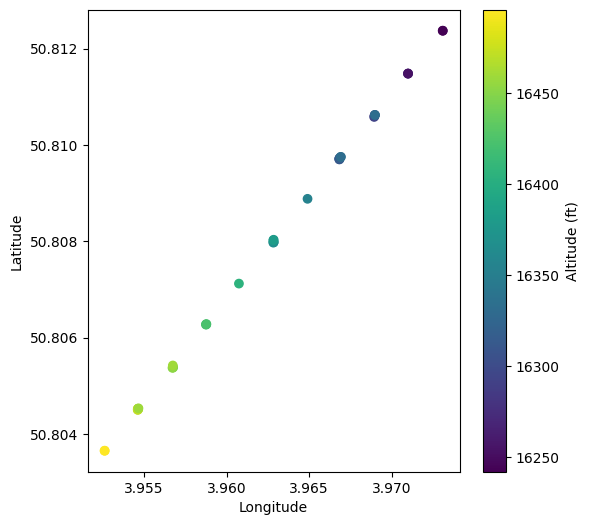

In [35]:
plt.figure(figsize=(6,6))
plt.scatter(flight['lon'], flight['lat'], c=flight['altitude'], cmap='viridis')
plt.colorbar(label='Altitude (ft)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

3. Définition de métriques

In [36]:
flight.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44 entries, 323 to 5704
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   icao          44 non-null     object        
 1   registration  43 non-null     object        
 2   altitude      43 non-null     float64       
 3   velocity      42 non-null     float64       
 4   heading       41 non-null     float64       
 5   lat           40 non-null     float64       
 6   lon           39 non-null     float64       
 7   timestamp     44 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 3.1+ KB


In [37]:
flight.describe()

,altitude,velocity,heading,lat,lon,timestamp
count,43.00000,42.000000,41.000000,40.000000,39.000000,44
mean,16001.55814,337.476190,54.756098,50.787646,3.962460,2025-11-19 14:46:38.996045568
min,164.00000,336.000000,5.000000,50.000000,3.952620,2025-11-19 14:46:11.166000
25%,16316.50000,337.000000,56.000000,50.805160,3.956740,2025-11-19 14:46:16.469499904
50%,16367.00000,337.000000,56.000000,50.807980,3.962850,2025-11-19 14:46:36.394000128
75%,16451.00000,338.000000,56.000000,50.809958,3.967925,2025-11-19 14:47:01.085250048
max,16496.00000,343.000000,56.000000,50.812370,3.973080,2025-11-19 14:47:17.269000
std,2473.87537,1.194256,7.964862,0.127760,0.006433,NaN


In [41]:
# Définition d'un seuil de déviation inquiétant :

def calculate_bearing(lat1, lon1, lat2, lon2, time1, time2):

    """
    On calcule la déviation en degrés, et on ajuste ensuite avec une normalisation
    en fonction de l'intervalle de temps delta_t écoulé entre time1 et time2.
    On calcule ensuite la déviation, on multiplie par delta_t et on divise par 20s
    pour obtenir la déviation moyenne sur les 20 secondes.
    """

    delta_t=(time2-time1).total_seconds()
    if(delta_t==0):
        return 0

    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    d_lon = lon2 - lon1
    x = np.sin(d_lon) * np.cos(lat2)
    y = np.cos(lat1)*np.sin(lat2) - np.sin(lat1)*np.cos(lat2)*np.cos(d_lon)
    bearing = np.degrees(np.arctan2(x, y))
    return ((bearing + 360) % 360) * delta_t / 20

In [43]:
# Définition de nouvelles colonnes pour étudier la position précédente
flight['prev_lat']=flight['lat'].shift(1)
flight['prev_lon']=flight['lon'].shift(1)
flight['prev_timestamp']=flight['timestamp'].shift(1)
flight['bearing_20s'] = flight.apply(
    lambda row: calculate_bearing(
        row['prev_lat'], row['prev_lon'],
        row['lat'], row['lon'],
        row['prev_timestamp'], row['timestamp']
    ) if pd.notnull(row['prev_lat']) else None,
    axis=1
)
flight.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44 entries, 323 to 5704
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   icao            44 non-null     object        
 1   registration    43 non-null     object        
 2   altitude        43 non-null     float64       
 3   velocity        42 non-null     float64       
 4   heading         41 non-null     float64       
 5   lat             40 non-null     float64       
 6   lon             39 non-null     float64       
 7   timestamp       44 non-null     datetime64[ns]
 8   prev_lat        39 non-null     float64       
 9   prev_lon        38 non-null     float64       
 10  prev_timestamp  43 non-null     datetime64[ns]
 11  bearing_20s     33 non-null     float64       
dtypes: datetime64[ns](2), float64(8), object(2)
memory usage: 4.5+ KB
